In [1]:
import os, sys
import pandas as pd
import numpy as np
import glob
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.dataset as ds
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import itertools
from tqdm.auto import tqdm
from multiprocessing import Pool
from stargazer.stargazer import Stargazer
from adjustText import adjust_text
import ipywidgets as widgets
import itertools

sns.set_context("paper", font_scale=1.7)

# Load Data

In [2]:
## All data
data_df = pd.read_feather('../../data/proc/all_hf.feather')
port_df = pd.read_feather('../../data/proc/port_hf.feather')
daily_data_df = pd.read_feather('../../data/proc/all_daily.feather')
daily_port_df = pd.read_feather('../../data/proc/portfolios_daily.feather')
cluster_class_df = pd.read_feather('../../data/proc/cluster_classifications.feather')

In [15]:
## Add additional info
data_df['return_pos'] = data_df['return']*(data_df['return'] > 0)
data_df['return_neg'] = data_df['return']*(data_df['return'] < 0)
port_df['return_pos'] = port_df['return']*(port_df['return'] > 0)
port_df['return_neg'] = port_df['return']*(port_df['return'] < 0)

# Realized Semicov/corrs

## Prep Data

### Clusters

In [7]:
def calc_cov_measures(data_df, permno_1, permno_2):

    merge_df = data_df.query('permno == @permno_1')[['datetime', 'return', 'return_pos', 'return_neg']].merge(
        data_df.query('permno == @permno_2')[['datetime', 'return', 'return_pos', 'return_neg']],
        how = 'inner', on = 'datetime'
    )

    # Add intermediate columns to speed up processing
    merge_df['return_x_times_y'] = merge_df['return_x']*merge_df['return_y']
    merge_df['return_x_2'] = np.square(merge_df['return_x'])
    merge_df['return_pos_x_2'] = np.square(merge_df['return_pos_x'])
    merge_df['return_neg_x_2'] = np.square(merge_df['return_neg_x'])
    merge_df['return_y_2'] = np.square(merge_df['return_y'])
    merge_df['return_pos_y_2'] = np.square(merge_df['return_pos_y'])
    merge_df['return_neg_y_2'] = np.square(merge_df['return_neg_y'])
    merge_df['return_pos_x_times_pos_y'] = merge_df['return_pos_x']*merge_df['return_pos_y']
    merge_df['return_pos_x_times_neg_y'] = merge_df['return_pos_x']*merge_df['return_neg_y']
    merge_df['return_neg_x_times_pos_y'] = merge_df['return_neg_x']*merge_df['return_pos_y']
    merge_df['return_neg_x_times_neg_y'] = merge_df['return_neg_x']*merge_df['return_neg_y']


    # Get daily results
    daily_merge_df = (
        merge_df.groupby(pd.Grouper(key = 'datetime', freq = '1d'), observed = True)
        .sum()
        .reset_index()
    )
    daily_merge_df.rename(
        columns = {'return_x_times_y': 'real_cov', 'return_pos_x_times_pos_y': 'real_cov_pp', 'return_pos_x_times_neg_y': 'real_cov_pn',
                   'return_neg_x_times_pos_y': 'real_cov_np', 'return_neg_x_times_neg_y': 'real_cov_nn',
                   'return_x_2': 'real_var_x', 'return_pos_x_2': 'real_var_pos_x', 'return_neg_x_2': 'real_var_neg_x',
                   'return_y_2': 'real_var_y', 'return_pos_y_2': 'real_var_pos_y', 'return_neg_y_2': 'real_var_neg_y',}, 
        inplace = True
    )

    # Add realized values
    daily_merge_df['real_cor'] =  daily_merge_df['real_cov']/np.sqrt(daily_merge_df['real_var_x']*daily_merge_df['real_var_y'])
    daily_merge_df['real_cor_pp'] =  daily_merge_df['real_cov_pp']/np.sqrt(daily_merge_df['real_var_x']*daily_merge_df['real_var_y'])
    daily_merge_df['real_cor_pn'] =  daily_merge_df['real_cov_pn']/np.sqrt(daily_merge_df['real_var_x']*daily_merge_df['real_var_y'])
    daily_merge_df['real_cor_np'] =  daily_merge_df['real_cov_np']/np.sqrt(daily_merge_df['real_var_x']*daily_merge_df['real_var_y'])
    daily_merge_df['real_cor_nn'] =  daily_merge_df['real_cov_nn']/np.sqrt(daily_merge_df['real_var_x']*daily_merge_df['real_var_y'])
    daily_merge_df['real_cor_n']  =  daily_merge_df['real_cor_pn'] + daily_merge_df['real_cor_np']
    daily_merge_df['real_beta']    =  daily_merge_df['real_cov']/daily_merge_df['real_var_y']
    daily_merge_df['real_beta_pp'] =  daily_merge_df['real_cov_pp']/daily_merge_df['real_var_y']
    daily_merge_df['real_beta_pn'] =  -1*daily_merge_df['real_cov_pn']/daily_merge_df['real_var_y']
    daily_merge_df['real_beta_np'] =  -1*daily_merge_df['real_cov_np']/daily_merge_df['real_var_y']
    daily_merge_df['real_beta_nn'] =  daily_merge_df['real_cov_nn']/daily_merge_df['real_var_y']
    
    # Add labels
    daily_merge_df['permno_x'] = permno_1
    daily_merge_df['permno_y'] = permno_2
    
    return merge_df, daily_merge_df

In [8]:
# list of permnos
permno_list = list(cluster_class_df['permno'].values) + ['84398']

# Running list of dataframes
df_list = []

# Multiprocess all possible combinations
def helper_func(permno_tuple):
    merge_df, daily_merge_df = calc_cov_measures(data_df, *permno_tuple)
    return daily_merge_df

with Pool(12) as p:
    for df in tqdm(p.imap_unordered(helper_func, itertools.product(permno_list, permno_list)),
                   total = len(list(itertools.product(permno_list, permno_list)))):
        df_list.append(df)

  0%|          | 0/225 [00:00<?, ?it/s]

In [9]:
# Dataframe of realized covariance info
rc_df = pd.concat(df_list, ignore_index = True)

## Add permno info
# x
temp_df = cluster_class_df.copy()
temp_df.columns = [c + '_x' for c in temp_df.columns]
rc_df = rc_df.merge(temp_df, how = 'left', on = 'permno_x')
# y
temp_df = cluster_class_df.copy()
temp_df.columns = [c + '_y' for c in temp_df.columns]
rc_df = rc_df.merge(temp_df, how = 'left', on = 'permno_y')

# Fix SPY case
rc_df['ticker_x'] = np.where(rc_df['permno_x'] == "84398", 'SPY', rc_df['ticker_x'])
rc_df['ticker_y'] = np.where(rc_df['permno_y'] == "84398", 'SPY', rc_df['ticker_y'])

# Ensure tickers are sorted by class order
rc_df['ticker_x'] = pd.Categorical(rc_df['ticker_x'], list(cluster_class_df['ticker'].values) + ['SPY'])
rc_df['ticker_y'] = pd.Categorical(rc_df['ticker_y'], list(cluster_class_df['ticker'].values) + ['SPY'])

### Portfolios

In [16]:
def calc_cov_measures(data_df, permno_1, permno_2):

    merge_df = data_df.query('permno == @permno_1')[['datetime', 'return', 'return_pos', 'return_neg']].merge(
        data_df.query('permno == @permno_2')[['datetime', 'return', 'return_pos', 'return_neg']],
        how = 'inner', on = 'datetime'
    )

    # Add intermediate columns to speed up processing
    merge_df['return_x_times_y'] = merge_df['return_x']*merge_df['return_y']
    merge_df['return_x_2'] = np.square(merge_df['return_x'])
    merge_df['return_pos_x_2'] = np.square(merge_df['return_pos_x'])
    merge_df['return_neg_x_2'] = np.square(merge_df['return_neg_x'])
    merge_df['return_y_2'] = np.square(merge_df['return_y'])
    merge_df['return_pos_y_2'] = np.square(merge_df['return_pos_y'])
    merge_df['return_neg_y_2'] = np.square(merge_df['return_neg_y'])
    merge_df['return_pos_x_times_pos_y'] = merge_df['return_pos_x']*merge_df['return_pos_y']
    merge_df['return_pos_x_times_neg_y'] = merge_df['return_pos_x']*merge_df['return_neg_y']
    merge_df['return_neg_x_times_pos_y'] = merge_df['return_neg_x']*merge_df['return_pos_y']
    merge_df['return_neg_x_times_neg_y'] = merge_df['return_neg_x']*merge_df['return_neg_y']


    # Get daily results
    daily_merge_df = (
        merge_df.groupby(pd.Grouper(key = 'datetime', freq = '1d'), observed = True)
        .sum()
        .reset_index()
    )
    daily_merge_df.rename(
        columns = {'return_x_times_y': 'real_cov', 'return_pos_x_times_pos_y': 'real_cov_pp', 'return_pos_x_times_neg_y': 'real_cov_pn',
                   'return_neg_x_times_pos_y': 'real_cov_np', 'return_neg_x_times_neg_y': 'real_cov_nn',
                   'return_x_2': 'real_var_x', 'return_pos_x_2': 'real_var_pos_x', 'return_neg_x_2': 'real_var_neg_x',
                   'return_y_2': 'real_var_y', 'return_pos_y_2': 'real_var_pos_y', 'return_neg_y_2': 'real_var_neg_y',}, 
        inplace = True
    )

    # Add realized values
    daily_merge_df['real_cor'] =  daily_merge_df['real_cov']/np.sqrt(daily_merge_df['real_var_x']*daily_merge_df['real_var_y'])
    daily_merge_df['real_cor_pp'] =  daily_merge_df['real_cov_pp']/np.sqrt(daily_merge_df['real_var_x']*daily_merge_df['real_var_y'])
    daily_merge_df['real_cor_pn'] =  daily_merge_df['real_cov_pn']/np.sqrt(daily_merge_df['real_var_x']*daily_merge_df['real_var_y'])
    daily_merge_df['real_cor_np'] =  daily_merge_df['real_cov_np']/np.sqrt(daily_merge_df['real_var_x']*daily_merge_df['real_var_y'])
    daily_merge_df['real_cor_nn'] =  daily_merge_df['real_cov_nn']/np.sqrt(daily_merge_df['real_var_x']*daily_merge_df['real_var_y'])
    daily_merge_df['real_cor_n']  =  daily_merge_df['real_cor_pn'] + daily_merge_df['real_cor_np']
    daily_merge_df['real_beta']    =  daily_merge_df['real_cov']/daily_merge_df['real_var_y']
    daily_merge_df['real_beta_pp'] =  daily_merge_df['real_cov_pp']/daily_merge_df['real_var_y']
    daily_merge_df['real_beta_pn'] =  -1*daily_merge_df['real_cov_pn']/daily_merge_df['real_var_y']
    daily_merge_df['real_beta_np'] =  -1*daily_merge_df['real_cov_np']/daily_merge_df['real_var_y']
    daily_merge_df['real_beta_nn'] =  daily_merge_df['real_cov_nn']/daily_merge_df['real_var_y']
    
    # Add labels
    daily_merge_df['permno_x'] = permno_1
    daily_merge_df['permno_y'] = permno_2
    
    return merge_df, daily_merge_df

In [17]:
# list of permnos
permno_list = list(port_df['permno'].unique()) + ['"84398"']

# Running list of dataframes
df_list = []

# Multiprocess all possible combinations
def helper_func(permno_tuple):
    merge_df, daily_merge_df = calc_cov_measures(port_df, *permno_tuple)
    return daily_merge_df

with Pool(12) as p:
    for df in tqdm(p.imap_unordered(helper_func, itertools.product(permno_list, permno_list)),
                   total = len(list(itertools.product(permno_list, permno_list)))):
        df_list.append(df)

  0%|          | 0/36 [00:00<?, ?it/s]

In [18]:
# Dataframe of realized covariance info
rc_port_df = pd.concat(df_list, ignore_index = True)

In [19]:
## Add ticker info
# Fix SPY case
rc_port_df['ticker_x'] = np.where(rc_port_df['permno_x'] == "84398", 'SPY', rc_port_df['permno_x'])
rc_port_df['ticker_y'] = np.where(rc_port_df['permno_y'] == "84398", 'SPY', rc_port_df['permno_y'])

# Ensure tickers are sorted by class order
rc_port_df['ticker_x'] = pd.Categorical(rc_port_df['ticker_x'], ['Good', 'Bad', 'Home', 'FAANG', 'SPY'])
rc_port_df['ticker_y'] = pd.Categorical(rc_port_df['ticker_y'], ['Good', 'Bad', 'Home', 'FAANG', 'SPY'])

## Exhibits

### Correlations

In [20]:
def plot_box(ax, x_1, x_2, y_1, y_2, lw = 2.5, color = 'white', ls = 'solid'):
    ax.plot([x_1, x_1], [y_1, y_2], lw = lw, color = color, ls = ls, *ax.get_xlim())
    ax.plot([x_1, x_2], [y_1, y_1], lw = lw, color = color, ls = ls, *ax.get_xlim())
    ax.plot([x_1, x_2], [y_2, y_2], lw = lw, color = color, ls = ls, *ax.get_xlim())
    ax.plot([x_2, x_2], [y_1, y_2], lw = lw, color = color, ls = ls, *ax.get_xlim())
    
def plot_heatmap(rc_df, statistic, date_start, date_end, scale_start, scale_end):
    
    date_start, date_end = np.min([date_start, date_end]), np.max([date_start, date_end])
    
    # Params
    fig, ax = plt.subplots(figsize = (17,12))
    statistic = statistic
    plot_data_df = rc_df.loc[rc_df['datetime'].between(str(date_start), str(date_end)), 
                             ['ticker_x', 'ticker_y', statistic]]
#     rc_df.loc[rc_df['datetime'].between(str('20200101'), str('20210101')), 
#                              ['ticker_x', 'ticker_y', statistic]]
    

    # Plot
    pivot_stat_df = plot_data_df.groupby(['ticker_x', 'ticker_y'])[[statistic]].mean().reset_index().pivot('ticker_x', 'ticker_y', statistic)
    sns.heatmap(pivot_stat_df, cmap = 'Spectral', alpha = 0.8, vmin = scale_start, vmax = scale_end, #vmin = -0.5, vmax = 1, 
               ax = ax, annot=True, square = True, annot_kws={"fontsize":10})

    # Lines for clusters
    plot_box(ax, 0, 5, 0, 5  , color = 'k')
    plot_box(ax, 5, 9, 5, 9  , color = 'k')
    plot_box(ax, 9, 11, 9, 11, color = 'k')
    plot_box(ax, 9, 14, 9, 14, color = 'k', ls = '--')
    plot_box(ax, 0, 14, 0, 14, color = 'k', lw = 1)

    # Adjustments
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(f"{statistic.replace('_', ' ').title()}: {date_start}-{date_end}")
    
    plt.close(fig)
    
    return fig, ax, pivot_stat_df

In [21]:
def plot_heatmap_grid(rc_df, statistic, date_start, date_end, scale_start, scale_end):

    # Dates
    date_start, date_end = np.min([date_start, date_end]), np.max([date_start, date_end])
    
    # Set up plot
    fig, axs = plt.subplots(figsize = (20,5), nrows = 1, ncols = 4, 
                            gridspec_kw = {"width_ratios": (1, 1, 1, 0.05), "wspace": 0.1})
#     gs = axs[1, 2].get_gridspec()
#     # remove the underlying axes
#     for ax in axs[0:, -1]:
#         ax.remove()
#     axbig = fig.add_subplot(gs[0:, -1])

    # Grid of plots
    stats_list = ['real_cor_pp', 'real_cor_n', 'real_cor_nn']
    names_list = ['$\\mathbf{P}_t$', '$\\mathbf{M}_t^+ + \\mathbf{M}_t^-$', '$\\mathbf{N}_t$']
    pivot_stat_dfs = []
    for i in range(len(stats_list)):

        # Get data
        statistic = stats_list[i]
        plot_data_df = rc_df.loc[rc_df['datetime'].between(str(date_start), str(date_end)), 
                                 ['ticker_x', 'ticker_y', statistic]]
        pivot_stat_df = plot_data_df.groupby(['ticker_x', 'ticker_y'])[[statistic]].mean().reset_index().pivot('ticker_x', 'ticker_y', statistic)
        pivot_stat_dfs.append(pivot_stat_df)

        # Plots
        ax = axs.reshape(-1)[i]
        sns.heatmap(pivot_stat_df, cmap = 'Spectral', alpha = 0.8, vmin = scale_start, vmax = scale_end, #vmin = -0.5, vmax = 1, 
                   ax = ax, cbar_ax = axs.reshape(-1)[-1], square = True)#, annot = True, annot_kws={"fontsize":6})
        ax.set_title(f'{names_list[i]}')

        # Lines for clusters
        plot_box(ax, 0, 5, 0, 5, lw = 1)
        plot_box(ax, 5, 9, 5, 9, lw = 1)
        plot_box(ax, 9, 11, 9, 11, lw = 1)
        plot_box(ax, 9, 14, 9, 14, lw = 1, ls = '--')
        plot_box(ax, 0, 14, 0, 14, lw = 1)


    # # Adjustments
    for ax in axs[:3].reshape(-1):
        ax.set_xlabel('')
        ax.set_ylabel('')
        
    plt.close(fig)

    return fig, axs, pivot_stat_dfs

In [22]:
def format_heatmap_latex(
    pivot_stat_df, table_name, output_filename, date_start, date_end, additional_notes=""
):
    
    pivot_stat_df.columns.name = None
    pivot_stat_df.index.name = None

    latex_header = (r"""
    \begin{table}[!h] \centering
    \caption{table_name}
    \small
    \begin{threeparttable}
    \begin{tabular}{@{\extracolsep{1pt}}l|ccccccccccccccc}
    \toprule
    \toprule
    """
    .replace("table_name", table_name)
    )
    
    latex_footer = (
        r"""
    \bottomrule
    \bottomrule
    \end{tabular}
    \begin{tablenotes}[flushleft]
    \small
    \item\textit{Note:} The sample consists of 5-minute intradaily returns for each stock from date_start-date_end. additional_notes
    \end{tablenotes}
    \end{threeparttable}
    \end{table}
    """
    .replace("date_start", str(date_start))
    .replace("additional_notes", additional_notes)
    )
    if date_end != date_start:
        latex_footer = latex_footer.replace("date_end", str(date_end))
    else:
        latex_footer = latex_footer.replace("-date_end", '')
        

    latex_raw_table = pivot_stat_df.round(2).to_latex().split("\n")
    latex_table = latex_header + " \n".join(latex_raw_table[2:-3]) + latex_footer

    with open(output_filename, "+w") as f:
        f.write(latex_table)

#### Clusters

In [176]:
# Heatmap widget
def widget_f(statistic, date_start, date_end, scale_start, scale_end):
    fig, _, _ = plot_heatmap(rc_df, statistic, date_start, date_end, scale_start, scale_end)
    display(fig)
    return

widgets.interact(widget_f,
                 statistic = ['real_cor', 'real_cor_pp', 'real_cor_pn', 'real_cor_np', 'real_cor_nn'], 
                 date_start=widgets.IntSlider(min=2002, max=2021, step=1, value=2002),
                 date_end=widgets.IntSlider(min=2002, max=2022, step=1, value=2021),
                 scale_start=widgets.FloatSlider(min=-1, max=1, step=0.1, value=-0.4),
                 scale_end=widgets.FloatSlider(min=-1, max=1, step=0.1, value=0.7),
                );

interactive(children=(Dropdown(description='statistic', options=('real_cor', 'real_cor_pp', 'real_cor_pn', 're…

In [177]:
## Full sample
date_start, date_end = 2002, 2021
date_filename = 'fullsample'

# Main heatmap of correlations
fig, ax, pivot_stat_df = plot_heatmap(rc_df, "real_cor", date_start, date_end, -0.4, 0.7)
ax.set_title("")
fig.tight_layout()
fig.savefig(f"../../exhibits/real_corr_heat_{date_filename}.pdf")
format_heatmap_latex(
    pivot_stat_df.copy(),
    f'Realized Correlations ({date_start}-{date_end-1})',
    f"../../exhibits/real_corr_{date_filename}.tex",
    date_start,
    date_end-1,
    additional_notes="",
)

# Grid heatmap of correlations
fig, ax, pivot_stat_dfs = plot_heatmap_grid(rc_df, "real_cor", date_start, date_end, -0.4, 0.7)
fig.savefig(f"../../exhibits/real_semicorr_heat_{date_filename}.pdf", bbox_inches = 'tight')
stats_list = ['real_cor_pp', 'real_cor_n', 'real_cor_nn']
names_list = ['$\\mathbf{P}_t$', '$\\mathbf{M}_t^+ + \\mathbf{M}_t^-$', '$\\mathbf{N}_t$']
for i in range(len(pivot_stat_dfs)):
    format_heatmap_latex(
        pivot_stat_dfs[i].copy(),
        f'Realized Semiorrelations {names_list[i]} ({date_start}-{date_end-1})',
        f"../../exhibits/real_corr_{stats_list[i].split('_')[-1]}_{date_filename}.tex",
        date_start,
        date_end-1,
        additional_notes="",
    )

In [25]:
## Full sample
date_start, date_end = 2020, 2021
date_filename = 'just2020'

# Main heatmap of correlations
fig, ax, pivot_stat_df = plot_heatmap(rc_df, "real_cor", date_start, date_end, -0.4, 0.7)
ax.set_title("")
fig.tight_layout()
fig.savefig(f"../../exhibits/real_corr_heat_{date_filename}.pdf")
format_heatmap_latex(
    pivot_stat_df.copy(),
    f'Realized Correlations ({date_start})',
    f"../../exhibits/real_corr_{date_filename}.tex",
    date_start,
    date_end-1,
    additional_notes="",
)

# Grid heatmap of correlations
fig, ax, pivot_stat_dfs = plot_heatmap_grid(rc_df, "real_cor", date_start, date_end, -0.4, 0.7)
fig.savefig(f"../../exhibits/real_semicorr_heat_{date_filename}.pdf", bbox_inches = 'tight')
stats_list = ['real_cor_pp', 'real_cor_n', 'real_cor_nn']
names_list = ['$\\mathbf{P}_t$', '$\\mathbf{M}_t^+ + \\mathbf{M}_t^-$', '$\\mathbf{N}_t$']
for i in range(len(pivot_stat_dfs)):
    format_heatmap_latex(
        pivot_stat_dfs[i].copy(),
        f'Realized Semiorrelations {names_list[i]} ({date_start})',
        f"../../exhibits/real_corr_{stats_list[i].split('_')[-1]}_{date_filename}.tex",
        date_start,
        date_end-1,
        additional_notes="",
    )

In [26]:
## Full sample
date_start, date_end = 2019, 2020
date_filename = 'just2019'

# Main heatmap of correlations
fig, ax, pivot_stat_df = plot_heatmap(rc_df, "real_cor", date_start, date_end, -0.4, 0.7)
ax.set_title("")
fig.tight_layout()
fig.savefig(f"../../exhibits/real_corr_heat_{date_filename}.pdf")
format_heatmap_latex(
    pivot_stat_df.copy(),
    f'Realized Correlations ({date_start})',
    f"../../exhibits/real_corr_{date_filename}.tex",
    date_start,
    date_end-1,
    additional_notes="",
)

# Grid heatmap of correlations
fig, ax, pivot_stat_dfs = plot_heatmap_grid(rc_df, "real_cor", date_start, date_end, -0.4, 0.7)
fig.savefig(f"../../exhibits/real_semicorr_heat_{date_filename}.pdf", bbox_inches = 'tight')
stats_list = ['real_cor_pp', 'real_cor_n', 'real_cor_nn']
names_list = ['$\\mathbf{P}_t$', '$\\mathbf{M}_t^+ + \\mathbf{M}_t^-$', '$\\mathbf{N}_t$']
for i in range(len(pivot_stat_dfs)):
    format_heatmap_latex(
        pivot_stat_dfs[i].copy(),
        f'Realized Semiorrelations {names_list[i]} ({date_start})',
        f"../../exhibits/real_corr_{stats_list[i].split('_')[-1]}_{date_filename}.tex",
        date_start,
        date_end-1,
        additional_notes="",
    )

#### Portfolios

In [27]:
## Full sample
date_start, date_end = 2002, 2021
date_filename = 'fullsample'

# Main heatmap of correlations
fig, ax, pivot_stat_df = plot_heatmap(rc_port_df, "real_cor", date_start, date_end, -0.4, 0.7)
ax.set_title("")
fig.tight_layout()
fig.savefig(f"../../exhibits/real_corr_heat_{date_filename}_port.pdf")
format_heatmap_latex(
    pivot_stat_df.copy(),
    f'Realized Correlations for Equally-Weighted Portfolios ({date_start}-{date_end-1})',
    f"../../exhibits/real_corr_{date_filename}_port.tex",
    date_start,
    date_end-1,
    additional_notes=r"The good, bad, and home portfolios refer to Covid stock clusters from Bollerslev et al. (2021c).",
)

# Grid heatmap of correlations
fig, ax, pivot_stat_dfs = plot_heatmap_grid(rc_port_df, "real_cor", date_start, date_end, -0.4, 0.7)
fig.savefig(f"../../exhibits/real_semicorr_heat_{date_filename}_port.pdf", bbox_inches = 'tight')
stats_list = ['real_cor_pp', 'real_cor_n', 'real_cor_nn']
names_list = ['$\\mathbf{P}_t$', '$\\mathbf{M}_t^+ + \\mathbf{M}_t^-$', '$\\mathbf{N}_t$']
for i in range(len(pivot_stat_dfs)):
    format_heatmap_latex(
        pivot_stat_dfs[i].copy(),
        f'Realized Semiorrelations for Equally-Weighted Portfolios {names_list[i]} ({date_start}-{date_end-1})',
        f"../../exhibits/real_corr_{stats_list[i].split('_')[-1]}_{date_filename}_port.tex",
        date_start,
        date_end-1,
        additional_notes=r"The good, bad, and home portfolios refer to Covid stock clusters from Bollerslev et al. (2021c).",
    )

In [28]:
## Full sample
date_start, date_end = 2020, 2021
date_filename = 'just2020'

# Main heatmap of correlations
fig, ax, pivot_stat_df = plot_heatmap(rc_port_df, "real_cor", date_start, date_end, -0.4, 0.7)
ax.set_title("")
fig.tight_layout()
fig.savefig(f"../../exhibits/real_corr_heat_{date_filename}_port.pdf")
format_heatmap_latex(
    pivot_stat_df.copy(),
    f'Realized Correlations for Equally-Weighted Portfolios ({date_start})',
    f"../../exhibits/real_corr_{date_filename}_port.tex",
    date_start,
    date_end-1,
    additional_notes=r"The good, bad, and home portfolios refer to Covid stock clusters from Bollerslev et al. (2021c).",
)

# Grid heatmap of correlations
fig, ax, pivot_stat_dfs = plot_heatmap_grid(rc_port_df, "real_cor", date_start, date_end, -0.4, 0.7)
fig.savefig(f"../../exhibits/real_semicorr_heat_{date_filename}_port.pdf", bbox_inches = 'tight')
stats_list = ['real_cor_pp', 'real_cor_n', 'real_cor_nn']
names_list = ['$\\mathbf{P}_t$', '$\\mathbf{M}_t^+ + \\mathbf{M}_t^-$', '$\\mathbf{N}_t$']
for i in range(len(pivot_stat_dfs)):
    format_heatmap_latex(
        pivot_stat_dfs[i].copy(),
        f'Realized Semiorrelations for Equally-Weighted Portfolios {names_list[i]} ({date_start})',
        f"../../exhibits/real_corr_{stats_list[i].split('_')[-1]}_{date_filename}_port.tex",
        date_start,
        date_end-1,
        additional_notes=r"The good, bad, and home portfolios refer to Covid stock clusters from Bollerslev et al. (2021c).",
    )

In [29]:
## Full sample
date_start, date_end = 2019, 2020
date_filename = 'just2019'

# Main heatmap of correlations
fig, ax, pivot_stat_df = plot_heatmap(rc_port_df, "real_cor", date_start, date_end, -0.4, 0.7)
ax.set_title("")
fig.tight_layout()
fig.savefig(f"../../exhibits/real_corr_heat_{date_filename}_port.pdf")
format_heatmap_latex(
    pivot_stat_df.copy(),
    f'Realized Correlations for Equally-Weighted Portfolios ({date_start})',
    f"../../exhibits/real_corr_{date_filename}_port.tex",
    date_start,
    date_end-1,
    additional_notes=r"The good, bad, and home portfolios refer to Covid stock clusters from Bollerslev et al. (2021c).",
)

# Grid heatmap of correlations
fig, ax, pivot_stat_dfs = plot_heatmap_grid(rc_port_df, "real_cor", date_start, date_end, -0.4, 0.7)
fig.savefig(f"../../exhibits/real_semicorr_heat_{date_filename}_port.pdf", bbox_inches = 'tight')
stats_list = ['real_cor_pp', 'real_cor_n', 'real_cor_nn']
names_list = ['$\\mathbf{P}_t$', '$\\mathbf{M}_t^+ + \\mathbf{M}_t^-$', '$\\mathbf{N}_t$']
for i in range(len(pivot_stat_dfs)):
    format_heatmap_latex(
        pivot_stat_dfs[i].copy(),
        f'Realized Semiorrelations for Equally-Weighted Portfolios {names_list[i]} ({date_start})',
        f"../../exhibits/real_corr_{stats_list[i].split('_')[-1]}_{date_filename}_port.tex",
        date_start,
        date_end-1,
        additional_notes=r"The good, bad, and home portfolios refer to Covid stock clusters from Bollerslev et al. (2021c).",
    )

### Betas

In [178]:
def plot_beta_table(rc_df, date_start, date_end, scale_start, scale_end):

    # Params
#     grid_kws = {"height_ratios": (.9, .05), "hspace": .3}
#     fig, (ax, cbar_ax) = plt.subplots(figsize = (15,7), nrows = 2, gridspec_kw=grid_kws)
    fig, ax = plt.subplots(figsize = (17,5))
    plot_data_df = rc_df.loc[rc_df["datetime"].between(str(date_start), str(date_end))].query('permno_y == "84398"')[
        ["ticker_x", "real_beta", "real_beta_pp", "real_beta_np", "real_beta_pn", "real_beta_nn"]
    ].groupby(['ticker_x']).mean().query('ticker_x != "SPY"')

    # Plot
    # pivot_stat_df = plot_data_df.pivot('ticker_x', 'ticker_y', statistic)
    plot_data_df.columns = ['$\\beta$', '$\\beta^{\\mathbf{P}}$', '$\\beta^{\\mathbf{M^+}}$', 
                            '$\\beta^{\\mathbf{M^-}}$', '$\\beta^{\\mathbf{N}}$']
    sns.heatmap(plot_data_df.T, cmap = 'viridis', alpha = 0.8, vmin = scale_start, vmax = scale_end, 
               ax = ax, annot=True, square = True, annot_kws={"fontsize":10})

    # Adjustments
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(f"Realized Betas: {date_start}-{date_end}")

    # Lines for clusters
    plot_box(ax, 0, 5, 0, 5)
    plot_box(ax, 5, 9, 0, 5)
    plot_box(ax, 9, 11, 0, 5)
    
    # Fix layout
    plt.tight_layout()
    
    return fig, ax, plot_data_df

#### Clusters

In [179]:
# Heatmap widget
# Heatmap widget
def widget_f(date_start, date_end, scale_start, scale_end):
    return plot_beta_table(rc_df, date_start, date_end, scale_start, scale_end)

widgets.interact(widget_f, 
                 date_start=widgets.IntSlider(min=2000, max=2021, step=1, value=2000),
                 date_end=widgets.IntSlider(min=2000, max=2021, step=1, value=20201),
                 scale_start=widgets.FloatSlider(min=-3, max=2, step=0.1, value=0),
                 scale_end=widgets.FloatSlider(min=-1, max=2, step=0.1, value=1.3),
                );

interactive(children=(IntSlider(value=2000, description='date_start', max=2021, min=2000), IntSlider(value=202…

\begin{tabular}{lrrrrrrrrrrrrrr}
\toprule
ticker_x &     BA &    OXY &    RTX &    SLB &    SPG &   BIIB &   BKNG &   CHTR &   GILD &   AMZN &   NFLX &     FB &   AAPL &   GOOG \\
\midrule
$\beta$                &  0.979 &  1.010 &  0.904 &  1.074 &  0.782 &  1.079 &  1.003 &  0.677 &  1.039 &  1.312 &  1.253 &  1.307 &  1.240 &  1.148 \\
$\beta^{\mathbf{P}}$   &  0.618 &  0.675 &  0.544 &  0.724 &  0.563 &  0.742 &  0.728 &  0.583 &  0.694 &  0.801 &  0.932 &  0.838 &  0.729 &  0.681 \\
$\beta^{\mathbf{M^+}}$ &  0.119 &  0.172 &  0.086 &  0.186 &  0.168 &  0.197 &  0.226 &  0.243 &  0.176 &  0.135 &  0.309 &  0.189 &  0.105 &  0.099 \\
$\beta^{\mathbf{M^-}}$ &  0.115 &  0.158 &  0.080 &  0.172 &  0.154 &  0.185 &  0.214 &  0.231 &  0.162 &  0.128 &  0.289 &  0.169 &  0.104 &  0.093 \\
$\beta^{\mathbf{N}}$   &  0.595 &  0.664 &  0.525 &  0.709 &  0.540 &  0.719 &  0.716 &  0.568 &  0.683 &  0.774 &  0.919 &  0.827 &  0.720 &  0.659 \\
\bottomrule
\end{tabular}



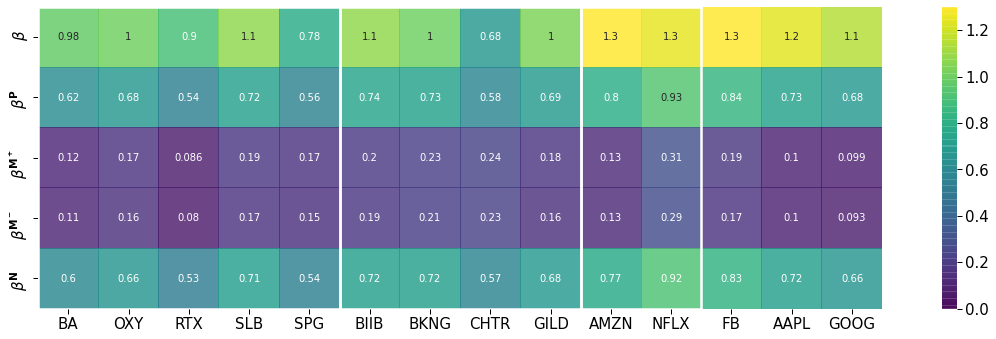

In [197]:
## 2002-2020
# Main heatmap of betas
fig, ax, plot_data_df = plot_beta_table(rc_df, 2002, 2021, 0, 1.3)
ax.set_title('')
plt.tight_layout()
plt.savefig('../../exhibits/real_beta_heat_fullsample.pdf')

print(plot_data_df.T.round(3).to_latex(escape = False))

\begin{tabular}{lrrrrrrrrrrrrrr}
\toprule
ticker_x &     BA &    OXY &    RTX &    SLB &    SPG &   BIIB &   BKNG &   CHTR &   GILD &   AMZN &   NFLX &     FB &   AAPL &   GOOG \\
\midrule
$\beta$                &  1.336 &  1.494 &  1.048 &  1.184 &  1.089 &  0.707 &  0.747 &  0.688 &  0.563 &  1.169 &  1.139 &  1.255 &  1.341 &  1.021 \\
$\beta^{\mathbf{P}}$   &  0.866 &  1.090 &  0.659 &  0.854 &  0.848 &  0.554 &  0.525 &  0.475 &  0.445 &  0.647 &  0.731 &  0.711 &  0.725 &  0.590 \\
$\beta^{\mathbf{M^+}}$ &  0.238 &  0.363 &  0.147 &  0.276 &  0.332 &  0.212 &  0.183 &  0.129 &  0.192 &  0.079 &  0.177 &  0.093 &  0.061 &  0.070 \\
$\beta^{\mathbf{M^-}}$ &  0.204 &  0.328 &  0.129 &  0.246 &  0.276 &  0.166 &  0.150 &  0.120 &  0.147 &  0.070 &  0.155 &  0.084 &  0.063 &  0.074 \\
$\beta^{\mathbf{N}}$   &  0.913 &  1.095 &  0.665 &  0.850 &  0.849 &  0.531 &  0.554 &  0.462 &  0.456 &  0.672 &  0.740 &  0.722 &  0.740 &  0.575 \\
\bottomrule
\end{tabular}



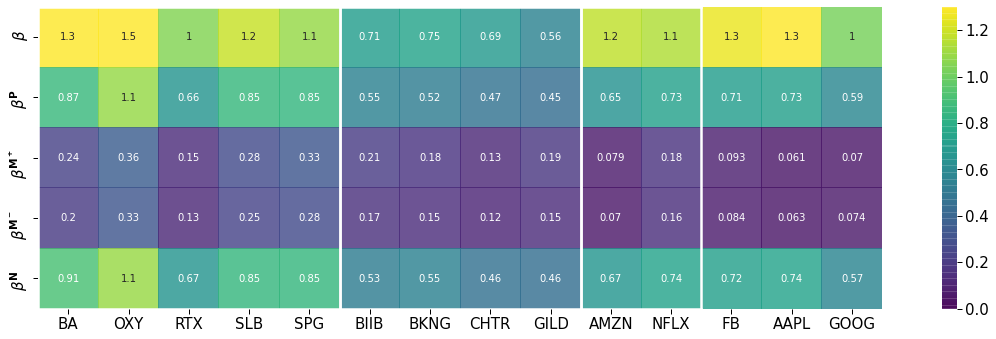

In [204]:
## 2020 Only
# Main heatmap of betas
fig, ax, plot_data_df = plot_beta_table(rc_df, 2020, 2021, 0, 1.3)
ax.set_title('')
plt.tight_layout()
plt.savefig('../../exhibits/real_beta_heat_just2020.pdf')

print(plot_data_df.T.round(3).to_latex(escape = False))

\begin{tabular}{lrrrrrrrrrrrrrr}
\toprule
ticker_x &     BA &    OXY &    RTX &    SLB &    SPG &   BIIB &   BKNG &   CHTR &   GILD &   AMZN &   NFLX &     FB &   AAPL &   GOOG \\
\midrule
$\beta$                &  0.977 &  0.953 &  1.008 &  1.155 &  0.567 &  1.027 &  0.635 &  0.708 &  0.994 &  1.249 &  1.547 &  1.281 &  1.243 &  1.141 \\
$\beta^{\mathbf{P}}$   &  0.721 &  0.760 &  0.626 &  0.899 &  0.523 &  0.797 &  0.517 &  0.562 &  0.688 &  0.721 &  1.002 &  0.799 &  0.734 &  0.679 \\
$\beta^{\mathbf{M^+}}$ &  0.216 &  0.297 &  0.127 &  0.313 &  0.250 &  0.287 &  0.207 &  0.194 &  0.189 &  0.084 &  0.233 &  0.160 &  0.081 &  0.096 \\
$\beta^{\mathbf{M^-}}$ &  0.205 &  0.261 &  0.102 &  0.296 &  0.221 &  0.262 &  0.179 &  0.186 &  0.176 &  0.076 &  0.225 &  0.147 &  0.108 &  0.091 \\
$\beta^{\mathbf{N}}$   &  0.676 &  0.751 &  0.612 &  0.864 &  0.515 &  0.779 &  0.505 &  0.526 &  0.672 &  0.688 &  1.003 &  0.789 &  0.697 &  0.649 \\
\bottomrule
\end{tabular}



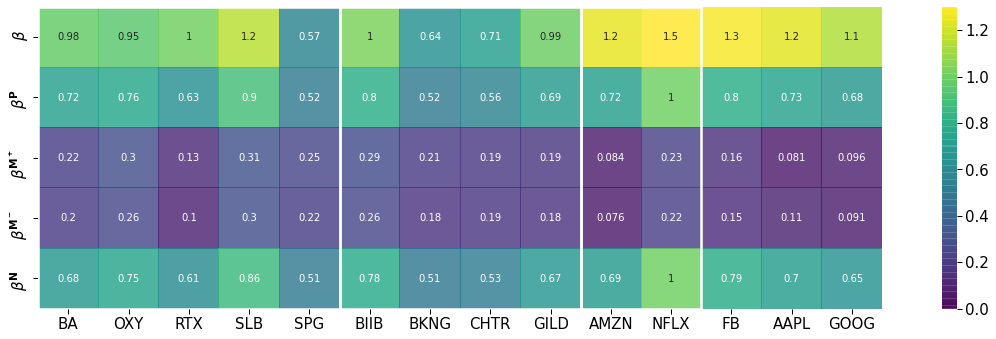

In [199]:
## 2019 Only
# Main heatmap of betas
fig, ax, plot_data_df = plot_beta_table(rc_df, 2019, 2020, 0, 1.3)
ax.set_title('')
plt.tight_layout()
plt.savefig('../../exhibits/real_beta_heat_just2019.pdf')

print(plot_data_df.T.round(3).to_latex(escape = False))

#### Portfolios

\begin{tabular}{lrrrr}
\toprule
ticker_x &   Good &    Bad &   Home &  FAANG \\
\midrule
$\beta$                &  0.993 &  0.950 &  1.287 &  1.252 \\
$\beta^{\mathbf{P}}$   &  0.590 &  0.527 &  0.797 &  0.710 \\
$\beta^{\mathbf{M^+}}$ &  0.092 &  0.049 &  0.150 &  0.080 \\
$\beta^{\mathbf{M^-}}$ &  0.087 &  0.044 &  0.143 &  0.080 \\
$\beta^{\mathbf{N}}$   &  0.581 &  0.515 &  0.783 &  0.702 \\
\bottomrule
\end{tabular}



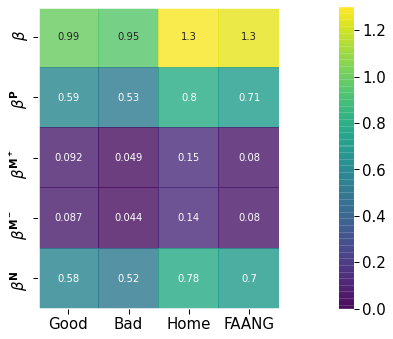

In [203]:
## 2002-2020
# Main heatmap of betas
fig, ax, plot_data_df = plot_beta_table(rc_port_df, 2002, 2021, 0, 1.3)
ax.set_title('')
plt.tight_layout()
plt.savefig('../../exhibits/real_beta_heat_fullsample_port.pdf')

print(plot_data_df.T.round(3).to_latex(escape = False))

\begin{tabular}{lrrrr}
\toprule
ticker_x &   Good &    Bad &   Home &  FAANG \\
\midrule
$\beta$                &  0.676 &  1.233 &  1.154 &  1.185 \\
$\beta^{\mathbf{P}}$   &  0.397 &  0.740 &  0.653 &  0.622 \\
$\beta^{\mathbf{M^+}}$ &  0.076 &  0.146 &  0.092 &  0.037 \\
$\beta^{\mathbf{M^-}}$ &  0.057 &  0.130 &  0.082 &  0.036 \\
$\beta^{\mathbf{N}}$   &  0.413 &  0.769 &  0.675 &  0.637 \\
\bottomrule
\end{tabular}



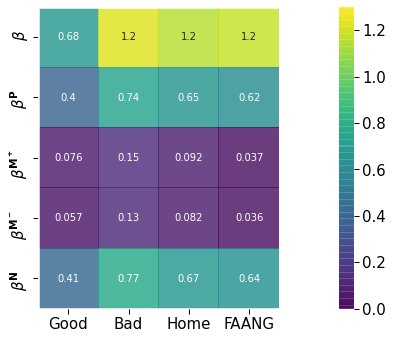

In [201]:
## 2020
# Main heatmap of betas
fig, ax, plot_data_df = plot_beta_table(rc_port_df, 2020, 2021, 0, 1.3)
ax.set_title('')
plt.tight_layout()
plt.savefig('../../exhibits/real_beta_heat_just2020_port.pdf')

print(plot_data_df.T.round(3).to_latex(escape = False))

\begin{tabular}{lrrrr}
\toprule
ticker_x &   Good &    Bad &   Home &  FAANG \\
\midrule
$\beta$                &  0.841 &  0.932 &  1.398 &  1.292 \\
$\beta^{\mathbf{P}}$   &  0.514 &  0.558 &  0.809 &  0.701 \\
$\beta^{\mathbf{M^+}}$ &  0.093 &  0.093 &  0.106 &  0.045 \\
$\beta^{\mathbf{M^-}}$ &  0.084 &  0.082 &  0.107 &  0.049 \\
$\beta^{\mathbf{N}}$   &  0.504 &  0.549 &  0.802 &  0.685 \\
\bottomrule
\end{tabular}



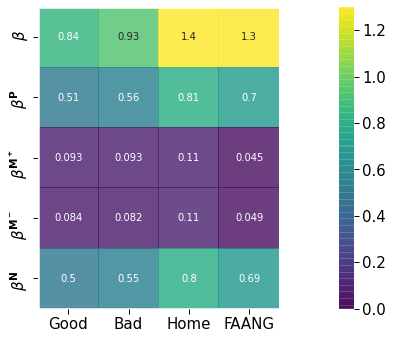

In [202]:
## 2019
# Main heatmap of betas
fig, ax, plot_data_df = plot_beta_table(rc_port_df, 2019, 2020, 0, 1.3)
ax.set_title('')
plt.tight_layout()
plt.savefig('../../exhibits/real_beta_heat_just2019_port.pdf')

print(plot_data_df.T.round(3).to_latex(escape = False))